[what is `torch.nn` really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

I really ought to understand how all of the parts work:
* `torch.nn`
* `torch.optim`
* `Dataset`
* `DataLoader`


In [1]:
from pathlib import Path # stdlib library for handling paths
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content 
    (PATH / FILENAME).open("wb").write(content)

import pickle 
import gzip 

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


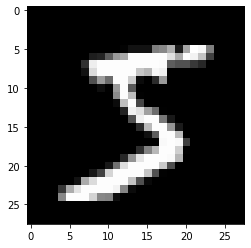

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 

plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)

Convert the data to `torch.tensor`

In [3]:
import torch 

x_train, y_train, x_valid, y_valid = map( torch.tensor, 
    (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train) 
print(x_train.shape)
print(y_train.min(), y_train.max()) # class labels

# sample x imdim

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# neural net from scratch

In [4]:
import math 

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_() # turn it on
bias = torch.zeros(10, requires_grad=True)

Any Python object/callable is a valid model

In [5]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    """Forward pass."""
    return log_softmax(xb @ weights + bias) # lin comb is in here

In [6]:
batch_size = 64

xb = x_train[0:batch_size]
preds = model(xb) # forward pass
print(preds[0], preds.shape)

tensor([-2.1899, -2.1489, -2.0443, -2.3620, -2.5956, -2.2282, -2.9308, -2.5269,
        -2.4642, -1.9168], grad_fn=<SelectBackward>) torch.Size([64, 10])


The `preds` tensor also contains a gradient function! We will use this to perform backpropagation.

In [7]:
def nll(input, target):
    """Negative log-likelihood loss."""
    return -input[range(target.shape[0]), target].mean()

loss_func = nll 

In [8]:
yb = y_train[0:batch_size] # exact 
print(loss_func(preds, yb))

tensor(2.3551, grad_fn=<NegBackward>)


In [9]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb).item())

0.109375


Training loop will:
* grab a mini-batch
* push it forward
* calculate the loss
* use `loss.backward()` to update gradients of model

We make sure to wrap this all in `torch.no_grad()` so that we do not include these calcs within the gradient calc. `loss.backward()` adds the gradients to the current buffer; we must make sure to clear this out.

In [11]:
lr = 0.5
epochs = 10

for epoch in range(epochs):
    for i in range((n - 1) // batch_size + 1):

        start_i = i * batch_size
        end_i = start_i + batch_size
        
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]

        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward() # compute grads, add to buffer
        # perform update steps
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias * lr
            # zero out for next iteration
            weights.grad.zero_()
            bias.grad.zero_()
            
    if epoch % (10-1) == 0:
        pred_epoch = model(x_train)
        loss_epoch = loss_func(pred_epoch, y_train)
        acc_epoch = accuracy(pred_epoch, y_train)
        print(f"{loss_epoch.item():.3}, {acc_epoch.item():.3}")            

0.255, 0.928
0.254, 0.929


## `torch.nn.functional` contains most useful functions 

For example, loss functions

In [12]:
import torch.nn.functional as F 

loss_func = F.cross_entropy

def model(xb):
    """Cross_entroy contains both nll loss and log softmax activation"""
    return xb @ weights + bias

loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0446, grad_fn=<NllLossBackward>), tensor(1.))

## `torch.nn.Module` and `torch.nn.Parameter` 

`nn.Module` is a class-tracking state. It also has useful attributes `.parameters()` and `.zero_grad()`. We must implement the (virtual?) functions `__init__()` and `forward`

In [13]:
class Mnist_Logistic(torch.nn.Module): # sub-classes the base class `nn.Module`
    def __init__(self):
        super().__init__()
        self.weights = torch.nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = torch.nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        """Called when we invoke our instance as a function."""
        return xb @ self.weights + self.bias

In [14]:
model = Mnist_Logistic()

print(loss_func(model(xb), yb))

tensor(2.4948, grad_fn=<NllLossBackward>)


When we did by scratch, we needed to update parameters by hand and manually zero out each gradient. Now, we can use the following:

In [42]:
def fit(num_epochs=2):
    for epoch in range(num_epochs):
        for i in range((n - 1) // batch_size + 1):
            start_i = i * batch_size
            end_i = start_i + batch_size

            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]

            pred = model(xb)
            loss = loss_func(pred, yb)

            # Updates go here!
            loss.backward() # calc grads
            with torch.no_grad():
                for p in model.parameters():
                    p -= lr * p.grad
                model.zero_grad() # zero all of them out

        if (epoch+1) % 10 == 0:
            pred_epoch = model(x_train)
            loss_epoch = loss_func(pred_epoch, y_train)
            acc_epoch = accuracy(pred_epoch, y_train)
            print(f"Epoch #{epoch+1:>3}:  {loss_epoch.item():>4.3}, {acc_epoch.item():>4.3}")      


In [43]:
fit(100)

Epoch # 10:  0.237, 0.932
Epoch # 20:  0.237, 0.932
Epoch # 30:  0.236, 0.932
Epoch # 40:  0.236, 0.932
Epoch # 50:  0.236, 0.932
Epoch # 60:  0.235, 0.933
Epoch # 70:  0.235, 0.933
Epoch # 80:  0.235, 0.933
Epoch # 90:  0.235, 0.933
Epoch #100:  0.235, 0.933
